# Basic Model

Build a single steady disc model and compute the composition using the default abundances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-talk')

### Define constants describing the disc model

In [2]:
Mdot_gas = 1e-8
Mdot_dust = 1e-9
Stokes = 0.01

T = lambda R: 150*(R/Rau)**-0.5
alpha = lambda R: 1e-3

### Build a grid and the background disc model

In [3]:
from drift_composition.planet_growth import seed_mass, Planet, PlanetEnv, mass_growth
from drift_composition.constants import Mearth, Msun, Rau, yr
from drift_composition.grid import Grid
from drift_composition.disc import DiscModel
from drift_composition.molecule import get_molecular_properties

grid = Grid(0.1*Rau, 30*Rau, 512)

DM = DiscModel(grid, Mdot_gas, alpha, T)

DM.compute_dust_surface_density(Mdot_dust, Stokes)

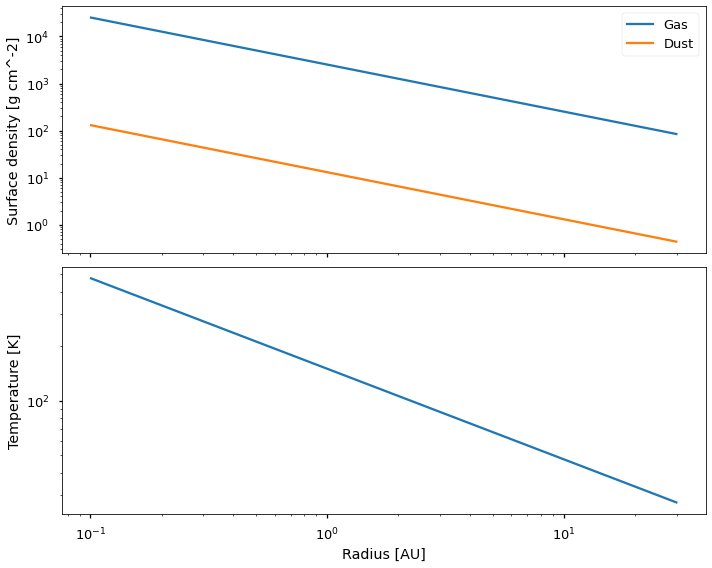

In [4]:
f, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

ax[0].loglog(grid.Rc/Rau, DM.Sigma_gas, label='Gas')
ax[0].loglog(grid.Rc/Rau, DM.Sigma_dust, label='Dust')
ax[0].set_ylabel('Surface density [g cm^-2]')
ax[0].legend()

ax[1].loglog(grid.Rc/Rau, T(grid.Rc))
ax[1].set_xlabel('Radius [AU]')
ax[1].set_ylabel('Temperature [K]')
ax[0].legend()

f.tight_layout()

### Compute the chemical structure

In [5]:
species, abundances = get_molecular_properties()
DM.compute_chemistry(species, abundances )

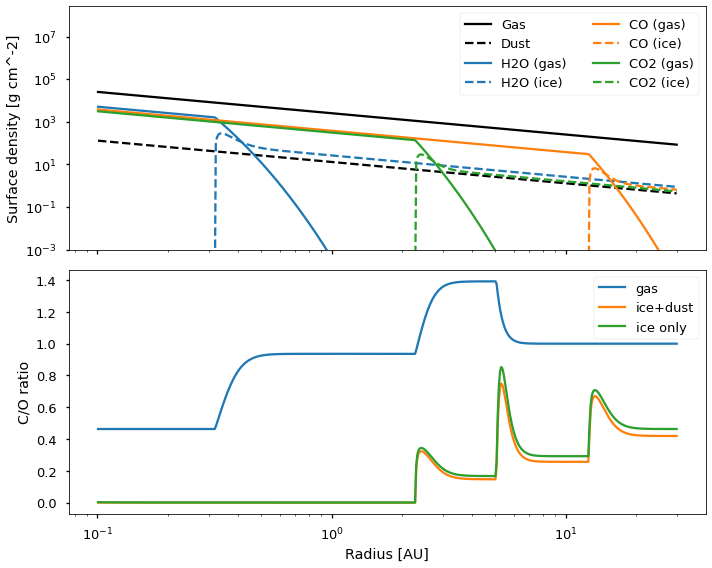

<Figure size 748.8x514.8 with 0 Axes>

In [6]:
f, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

ax[0].loglog(grid.Rc/Rau, DM.Sigma_gas, label='Gas', c='k')
ax[0].loglog(grid.Rc/Rau, DM.Sigma_dust, label='Dust', c='k', ls='--')
for spec in ['H2O', 'CO', 'CO2']:
    l,= ax[0].loglog(grid.Rc/Rau, DM.Sigma_mol[spec][:,0], label=f'{spec} (gas)')
    ax[0].loglog(grid.Rc/Rau, DM.Sigma_mol[spec][:,1], label=f'{spec} (ice)', ls='--', c=l.get_color())

ax[0].set_ylabel('Surface density [g cm^-2]')
ax[0].legend(ncol=2)
ax[0].set_ylim(ymin=1e-3)

columns = DM.compute_elemental_column()
C2O = columns['C']/columns['O']

columns = DM.compute_elemental_column(dust=None)
C2O_ice = columns['C']/columns['O']

plt.figure()
ax[1].semilogx(grid.Rc/Rau, C2O[:,0], label='gas')
ax[1].semilogx(grid.Rc/Rau, C2O[:,1], label='ice+dust')
ax[1].semilogx(grid.Rc/Rau, C2O_ice[:,1], label='ice only')

ax[1].set_xlabel('Radius [AU]')
ax[1].set_ylabel('C/O ratio')
ax[1].legend()

f.tight_layout()

In [7]:
species, abundances = get_molecular_properties()

f_comp = dict(zip([spec.name for spec in species],np.zeros(len(species))))

grid = Grid(0.1*Rau, 30*Rau, 512)

planet_ini = Planet(0.1*Mearth/Msun, 0.1*Mearth/Msun, 1e-10, f_comp, 5.0*Rau)
print(planet_ini.f_comp)

p_env = PlanetEnv(grid, alpha(grid.Rc), 2.35, 1.0)

dt = 10000
Nt = int(1e2)

masses = []
mcs = []
mgs = []
mco = []

print(p_env.temp(T(grid.Rc),planet_ini.dist), planet_ini.mass)

planet = planet_ini
for kk in range(Nt):
    planet = mass_growth(planet, p_env, DM, T(grid.Rc), dt)
    masses.append(planet.mass)
    mcs.append(planet.mc)
    mgs.append(planet.mg)
    mco.append(planet.f_comp['CO'])
    #help(planet)
    #print(planet.mass)

{'H2O': 0.0, 'CO2': 0.0, 'CO': 0.0, 'C': 0.0, 'N2': 0.0, 'NH3': 0.0, 'Ar': 0.0, 'Kr': 0.0, 'Xe': 0.0}
66.95526686218876 3.003505461098011e-07


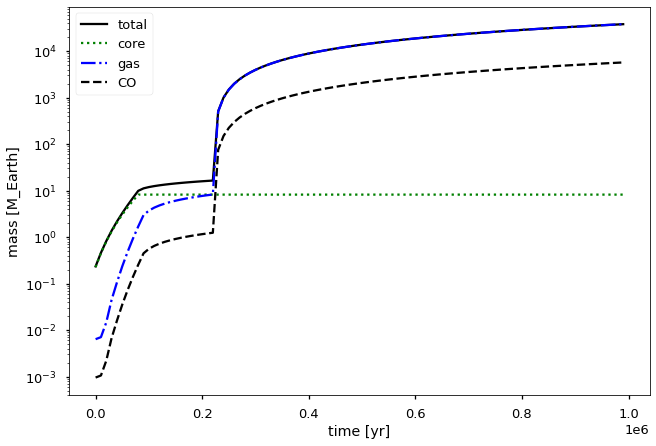

In [9]:
import matplotlib.pyplot as plt    
plt.plot(np.arange(Nt)*dt, np.array(masses)*Msun/Mearth, 'k-', label='total')
plt.plot(np.arange(Nt)*dt, np.array(mcs)*Msun/Mearth, 'g:', label='core')
plt.plot(np.arange(Nt)*dt, np.array(mgs)*Msun/Mearth, 'b-.', label='gas')
plt.plot(np.arange(Nt)*dt, np.array(mco)*Msun/Mearth, 'k--', label='CO')
plt.yscale('log')
plt.xlabel("time [yr]")
plt.ylabel("mass [M_Earth]")
plt.legend()
plt.show()